I am following the Deep Learning course of Mike X Cohen on Udemy, Lecture 82

In [1]:
### import libraries

# for DL modeling
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

# Import and process the data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
# describe the data
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
# list number of unique values per column

for i in data.keys():
  print(f'{i} has {len(np.unique(data[i]))} unique values')

fixed acidity has 96 unique values
volatile acidity has 143 unique values
citric acid has 80 unique values
residual sugar has 91 unique values
chlorides has 153 unique values
free sulfur dioxide has 60 unique values
total sulfur dioxide has 144 unique values
density has 436 unique values
pH has 89 unique values
sulphates has 96 unique values
alcohol has 65 unique values
quality has 6 unique values


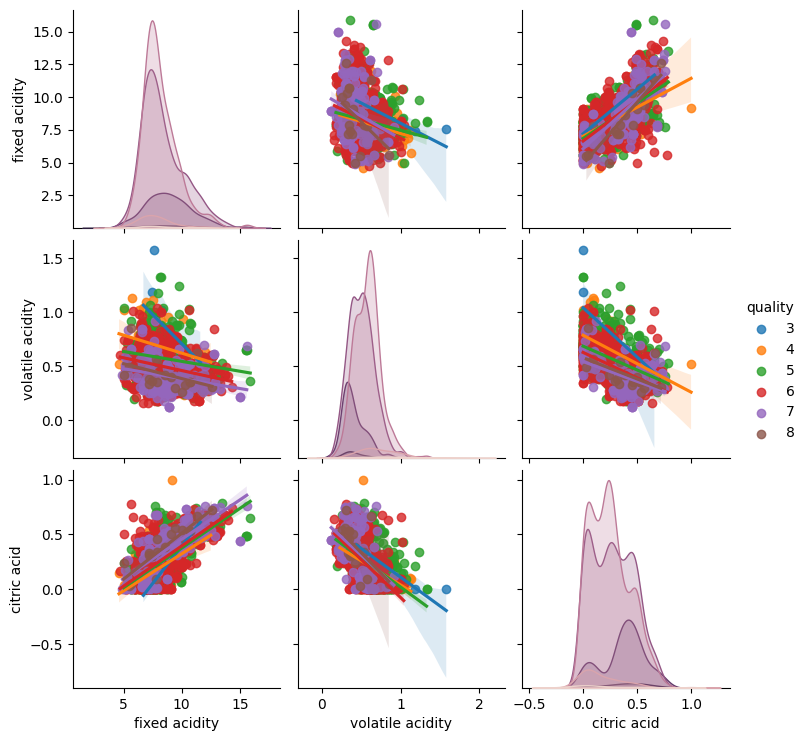

In [5]:
# pairwise plots
cols2plot = ['fixed acidity','volatile acidity','citric acid','quality']
sns.pairplot(data[cols2plot],kind='reg',hue='quality')
plt.show()

By eye, we can understand that citric acid and fixed acidity have positive correlation.

But the idea of deep learning is to discover relationships across these 11 different features of the data.

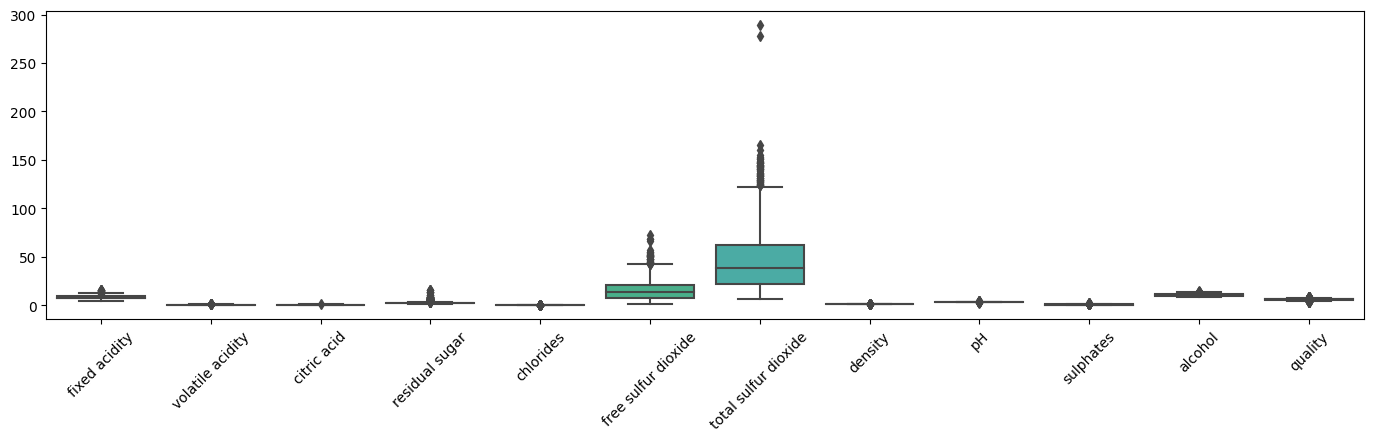

In [6]:
# plot some data
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()


# remove rows with outliers
data = data[data['total sulfur dioxide']<200]

We investigated the data and find outlier in "total sulfur dioxide" and we are gonna remove them because those outliers can be detrimental for deep learning. 

In [7]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality') # we want to predict quality so we dont want to z-scored it 

# z-score (written out for clarity)
for col in cols2zscore:
  meanval   = np.mean(data[col])
  stdev     = np.std(data[col],ddof=1)
  data[col] = (data[col]-meanval) / stdev

# can also do more compactly
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000
mean,1.779694e-17,1.156801e-16,1.779694e-17,-7.563699e-17,-1.512740e-16,-1.779694e-17,-7.118775e-17,-8.357442e-14,3.025479e-16,8.008622e-17,-5.872989e-16,5.634314
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.806630
min,-2.135419e+00,-2.280048e+00,-1.391387e+00,-1.168783e+00,-1.604073e+00,-1.422392e+00,-1.262186e+00,-3.545821e+00,-3.708218e+00,-1.936711e+00,-1.898626e+00,3.000000
25%,-7.003882e-01,-7.715838e-01,-9.283861e-01,-4.524372e-01,-3.720247e-01,-8.476045e-01,-7.594598e-01,-6.109478e-01,-6.585382e-01,-6.390204e-01,-8.650444e-01,5.000000
50%,-2.411785e-01,-4.528645e-02,-5.382836e-02,-2.375335e-01,-1.808448e-01,-1.770192e-01,-2.567340e-01,-6.214425e-04,-9.670044e-03,-2.261189e-01,-2.073106e-01,6.000000
75%,5.050372e-01,6.251419e-01,7.692848e-01,4.900487e-02,5.281955e-02,4.935662e-01,4.973546e-01,5.778618e-01,5.743113e-01,4.227263e-01,6.383472e-01,6.000000
max,4.350918e+00,5.876831e+00,3.753070e+00,9.289866e+00,1.112001e+01,5.379259e+00,3.733652e+00,3.682565e+00,4.532407e+00,7.913939e+00,4.208902e+00,8.000000


The std become 1 for all variables after z-scoring 

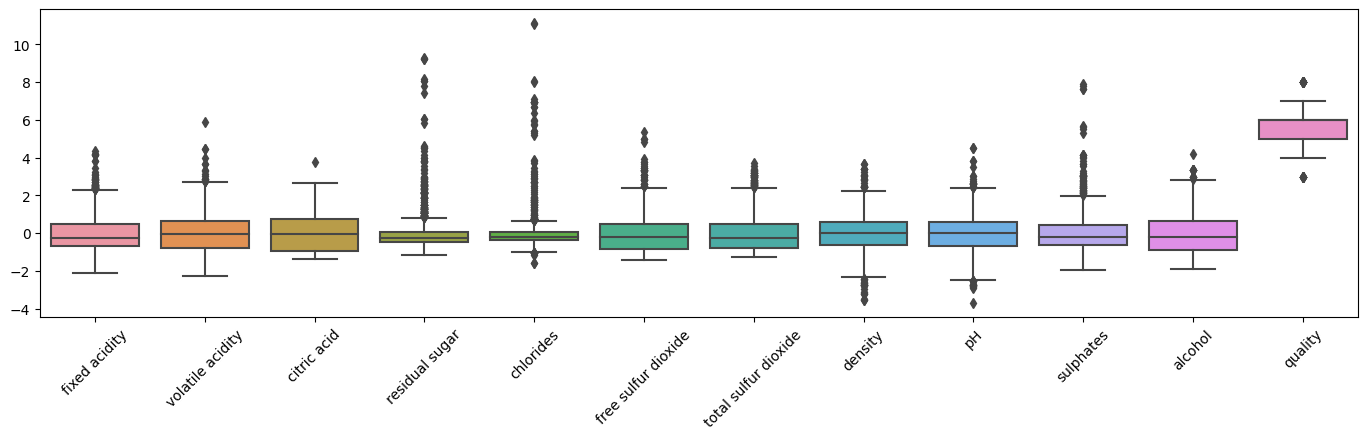

In [8]:
# check the plot again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

All data columns are in similar range

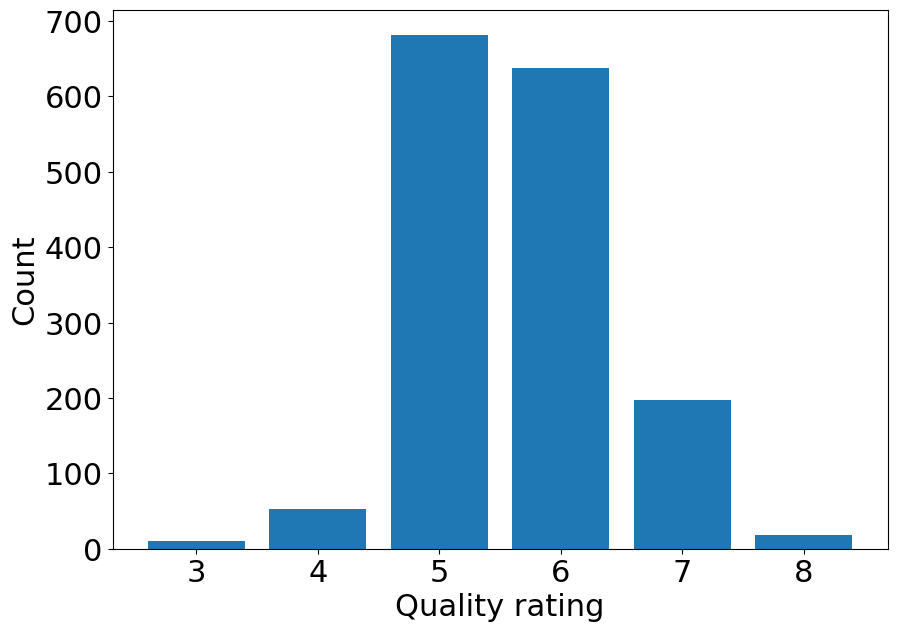

,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


In [9]:
# Check whether all quality values are equally represented

# distribution quality values
fig = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 22}) # increase font size in the figure

counts = data['quality'].value_counts()
plt.bar(list(counts.keys()),counts)
plt.xlabel('Quality rating')
plt.ylabel('Count')
plt.show()

# ! Binarize quality rating
# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

data[['quality','boolQuality']]

It is desirable to have roughly equal number of data points!

Until now, we preprocess the data, clean it and prepare for DL model!! 

# Re-organize the data: train/test in DataLoaders

In [10]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()

print( dataT.shape )
print( labels.shape )

# we'll actually need the labels to be a "tensor"
labels = labels[:,None]
print( labels.shape )

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


In [11]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,drop_last=True, shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [12]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader
# because the last data batches has missing data points, not equally distributed among batches

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


# Additional explorations

In [13]:
# 1) In a later video, we will use DL to predict residual sugar. Use seaborn to make a histogram of that data column.
#    Spend a minute to explore the visualization options in sns.histplot. For example, you can add a kernel density 
#    estimate, make the histogram bars purple, and so on.
# 
# 2) (Warning: This exercise is for people who are familiar with statistics.) Loop over all the variables in the dataset,
#    and perform an independent-samples t-test on the data for the binarized wine quality. Which variables are significantly
#    different between "low" and "high" quality wine?
# 